In [3]:
!pip install torchvision

     ---------------------------------------- 1.2/1.2 MB 8.4 MB/s eta 0:00:00


You should consider upgrading via the 'c:\waste-management\environ\Scripts\python.exe -m pip install --upgrade pip' command.


In [11]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model (make sure you save it during/after training)
model_path = 'save_model.pth'  # Replace with the path to your saved model
num_classes = 2  # Background and trash

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=num_classes)

# Ensure that the model is loaded to CPU if CUDA is not available
if not torch.cuda.is_available():
    pretrained_dict = torch.load(model_path, map_location=torch.device('cpu'))
else:
    pretrained_dict = torch.load(model_path)


model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Load the filtered state dict
model.load_state_dict(pretrained_dict)


model = model.to(device)
model.eval()

# Preprocess the new image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Perform inference
def get_segmentation_mask(model, image):
    with torch.no_grad():
        output = model(image)['out']
    return output

# Post-process the output to get the binary mask
def postprocess_output(output):
    # Get the predicted class for each pixel
    pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return pred

# Path to the new image


# Plot the original image and the segmentation mask
def plot_results(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    overlayed_image = overlay_mask(image, mask)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask Overlay")
    plt.imshow(overlayed_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



c:\waste-management\environ\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\waste-management\environ\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
import numpy as np
# Overlay the mask on the original image
def overlay_mask(image, mask):
    # Convert mask to rgba format
    mask_rgba = np.zeros((*mask.shape, 4), dtype=np.uint8)
    mask_rgba[mask == 1] = [255, 0, 0, 100]  # Set color and transparency for class 1 (trash)
    mask_rgba[mask == 0] = [0, 0, 0, 0]      # Set transparency for class 0 (background)

    # Ensure mask and image are of the same size
    mask_pil = Image.fromarray(mask_rgba)
    mask_pil = mask_pil.resize(image.size)

    # Convert PIL image to numpy array
    image_np = np.array(image)

    # Overlay mask on image
    overlay = Image.fromarray(image_np).convert("RGBA")
    overlay = Image.alpha_composite(overlay, mask_pil)

    return overlay


In [13]:
def generate_mask(new_image_path, display=True):
    # Preprocess the image
    image = preprocess_image(new_image_path).to(device)

    # Get the segmentation mask
    output = get_segmentation_mask(model, image)

    # Post-process to get the final binary mask
    binary_mask = postprocess_output(output)

    # Display the results
    if display:
        plot_results(new_image_path, binary_mask)

    return binary_mask

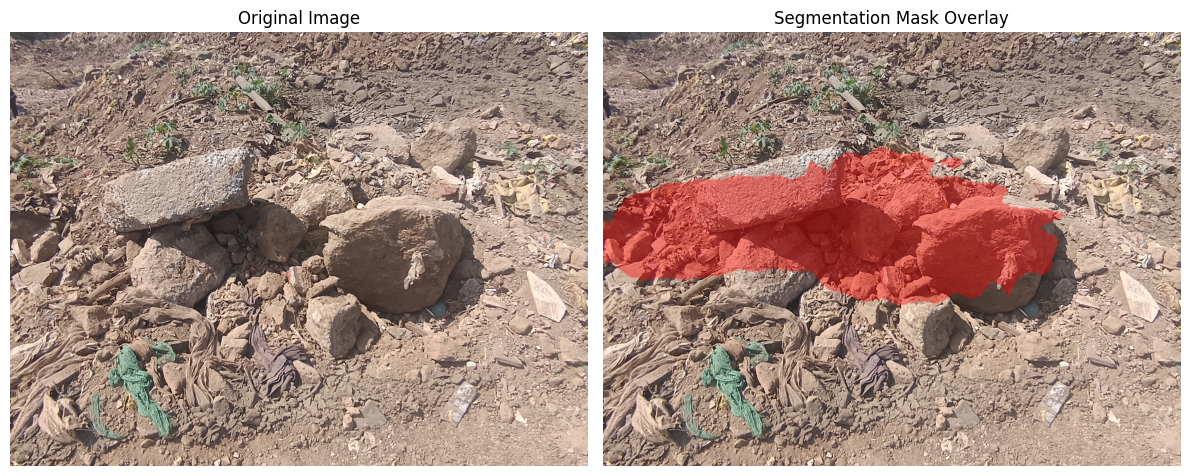

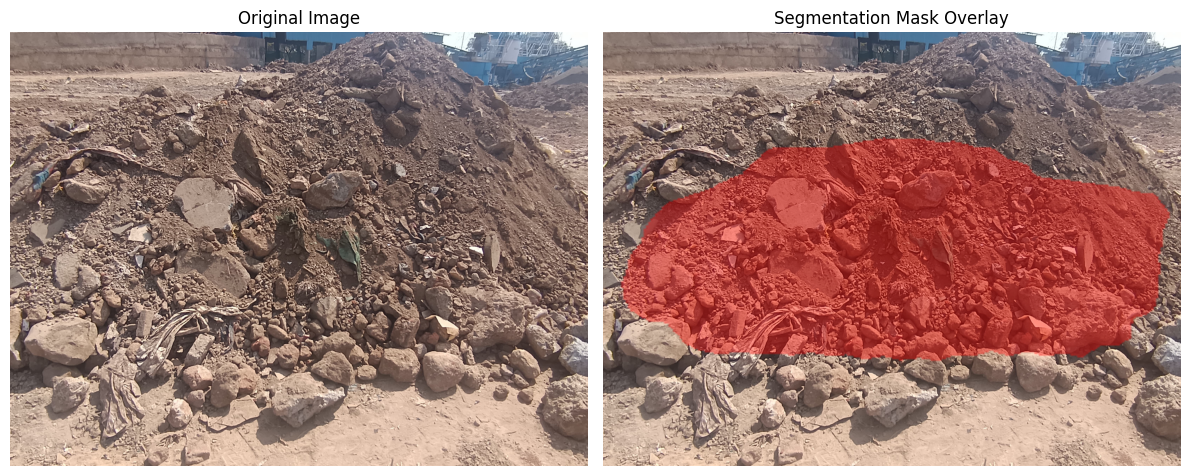

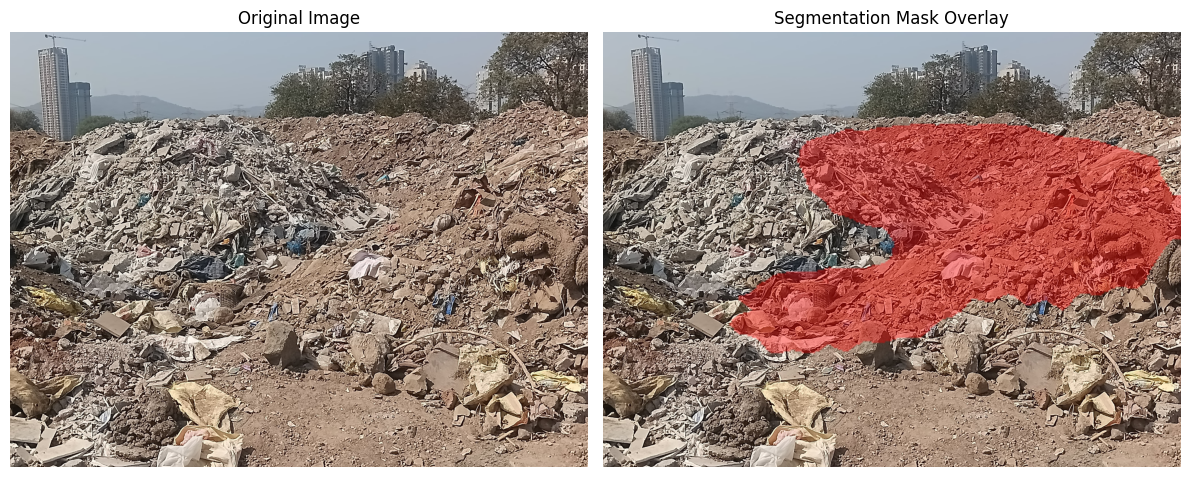

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
generate_mask('1.jpeg')
generate_mask('2.jpeg')
generate_mask('3.jpeg')